# WEEK 5

In [1]:
import zipfile
with zipfile.ZipFile('/content/FruitinAmazon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


In [3]:
# Define paths
train_dir = '/content/extracted_folder/FruitinAmazon/train'
test_dir = '/content/extracted_folder/FruitinAmazon/test'

In [4]:
# Get list of class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each class
random_images = []
class_names = []

for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    image_name = random.choice(os.listdir(class_path))  # Randomly select one image
    random_images.append(os.path.join(class_path, image_name))
    class_names.append(class_name)

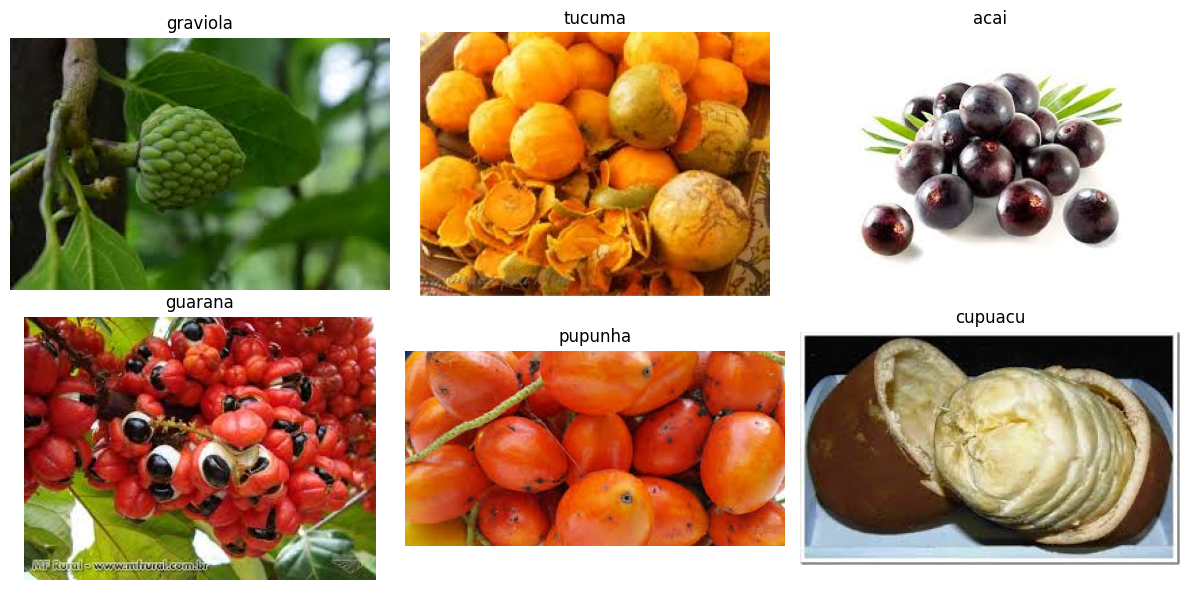

In [5]:
# Display images in a grid (2 rows)
plt.figure(figsize=(12, 6))
columns = (len(random_images) + 1) // 2
for i, img_path in enumerate(random_images):
    plt.subplot(2, columns, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(class_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

2. Check for Corrupted Image: Write a script that verifies whether the image in the train
directory are valid. If any corrupted images are found, the script must remove the image from
the directory and print the message which image have been removed, if none found print ”No
Corrupted Images Found.”
* Hint:
 * Iterate through each class subdirectory and check if each image is valid.
 * Use the Image.open() function to attempt to load each image.
 * If the image is corrupted i.e. raises an IOError or SyntaxError, remove the image from
the directory and print ```f"Removed corrupted image: {image_path}"```.
 * Maintain a list of all corrupted image paths for reporting.
* Expected Output: No corrupted images found.


In [6]:

# List to store corrupted image paths
corrupted_images = []

# Iterate through class directories
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify the image integrity
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")



# Final report
if corrupted_images:
    print(f"Total corrupted images removed: {len(corrupted_images)}")
else:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [7]:
# Define the path to your train directory and parameters
img_height = 128  # Desired image height
img_width = 128   # Desired image width
img_shape = (img_height, img_width,3)
batch_size = 32   # Number of images per batch
validation_split = 0.2  # 20% data for validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]


In [8]:
# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',         # Automatically infer the labels from subdirectories
    label_mode='int',          # Labels as integers (could also use 'categorical' or 'binary')
    image_size=(img_height, img_width),  # Resize images to this shape
    interpolation='nearest',   # Interpolation method for resizing
    batch_size=batch_size,     # Batch size for training
    shuffle=True,              # Shuffle the data
    validation_split=validation_split,  # Split data for training and validation
    subset='training',         # Specify this is for training subset
    seed=123                   # Random seed for reproducibility
)

# Apply the normalization (Rescaling) to the training dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.


In [9]:
# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',         # Automatically infer the labels from subdirectories
    label_mode='int',          # Labels as integers
    image_size=(img_height, img_width),  # Resize images
    interpolation='nearest',   # Interpolation method for resizing
    batch_size=batch_size,     # Batch size for validation
    shuffle=True,              # Shuffle the validation data
    validation_split=validation_split,  # Same validation split for validation
    subset='validation',       # Specify this is for validation subset
    seed=123                   # Random seed for reproducibility
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))



Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [10]:

# Define the model
modelcnn = keras.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=img_shape),  # (3, 3) filter, 32 filters input_layer= 128x128 for 3 layers:R,G,B
    layers.MaxPooling2D((2, 2), strides=2),  # Max pooling with (2, 2) filter, stride 2

    # Second Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # (3, 3) filter, 32 filters
    layers.MaxPooling2D((2, 2), strides=2),  # Max pooling with (2, 2) filter, stride 2

    # Flatten the output to feed into dense layers
    layers.Flatten(),

    # Fully connected hidden layers
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons

    # Output layer with the number of classes
    layers.Dense(6, activation='softmax')  # 6 classes for fruit types
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:

# Print the model summary
modelcnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
modelcnn.compile(
    optimizer='adam',  # Optimizer: Adam
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification with integer labels
    metrics=['accuracy']  # Evaluation metric: Accuracy
)

In [13]:
# Display the compiled model summary
modelcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
# Define the callbacks
callbacks = [
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        'best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_loss',  # Monitor validation loss
        mode='min',  # Minimize the validation loss
        verbose=1
    ),
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=10,  # Wait for 10 epochs before stopping
        restore_best_weights=True,  # Restore best weights after stopping
        verbose=1
    )
]

In [16]:
# Train the model
history = modelcnn.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    callbacks=callbacks  # Callbacks for early stopping and saving the best model
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2263 - loss: 1.8391
Epoch 1: val_loss improved from inf to 1.91492, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - accuracy: 0.2183 - loss: 1.8471 - val_accuracy: 0.2222 - val_loss: 1.9149
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.4277 - loss: 1.6114
Epoch 2: val_loss improved from 1.91492 to 1.75039, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step - accuracy: 0.4110 - loss: 1.6178 - val_accuracy: 0.1111 - val_loss: 1.7504
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4398 - loss: 1.4770
Epoch 3: val_loss did not improve from 1.75039
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step - accuracy: 0.4410 - loss: 1.4711 - val_accuracy: 0.1667 - val_loss: 1.7722
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4734 - loss: 1.2797
Epoch 4: val_loss did not improve from 1.75039
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.4835 - loss: 1.2667 - val_accuracy: 0.1111 - val_loss: 1.8116
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.6742 - loss: 0.9575
Epoch 5: val_loss improved from 1.75039 to 1.66724, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 780ms/step - accuracy: 0.6793 - loss: 0.9593 - val_accuracy: 0.4444 - val_loss: 1.6672
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8056 - loss: 0.7265
Epoch 6: val_loss did not improve from 1.66724
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.8021 - loss: 0.7291 - val_accuracy: 0.2778 - val_loss: 2.1730
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8304 - loss: 0.5991
Epoch 7: val_loss did not improve from 1.66724
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.8277 - loss: 0.6015 - val_accuracy: 0.3889 - val_loss: 1.6855
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9352 - loss: 0.3752
Epoch 8: val_loss improved from 1.66724 to 1.55249, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - accuracy: 0.9340 - loss: 0.3742 - val_accuracy: 0.2778 - val_loss: 1.5525
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9456 - loss: 0.2248
Epoch 9: val_loss did not improve from 1.55249
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.9418 - loss: 0.2313 - val_accuracy: 0.3333 - val_loss: 1.8227
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9902 - loss: 0.1551
Epoch 10: val_loss did not improve from 1.55249
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.9891 - loss: 0.1526 - val_accuracy: 0.3333 - val_loss: 1.6469
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9248 - loss: 0.1732
Epoch 11: val_loss did not improve from 1.55249
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.9262 - loss: 0.1680 - val_accuracy: 0.3889 - val_loss: 1.7193
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 1.0000 - loss: 0.0938
Epoch 12: val_loss did not improve from 1.55249
3/3 ━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 0.5000 - val_loss: 1.5422
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 1.0000 - loss: 0.0522
Epoch 15: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 1.0000 - loss: 0.0534 - val_accuracy: 0.5556 - val_loss: 1.7448
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 1.0000 - loss: 0.0346
Epoch 16: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 0.6111 - val_loss: 1.9066
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 1.0000 - loss: 0.0183
Epoch 17: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 0.6111 - val_loss: 2.3145
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 1.0000 - loss: 0.0144
Epoch 18: val_loss did not improve from 1.54220
3/3 

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    seed=28             # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))


Found 30 files belonging to 6 classes.


In [18]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelcnn.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7000 - loss: 1.0726
Test Loss: 1.0726, Test Accuracy: 0.7000



Plotting training history (accuracy and loss)


In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))


<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

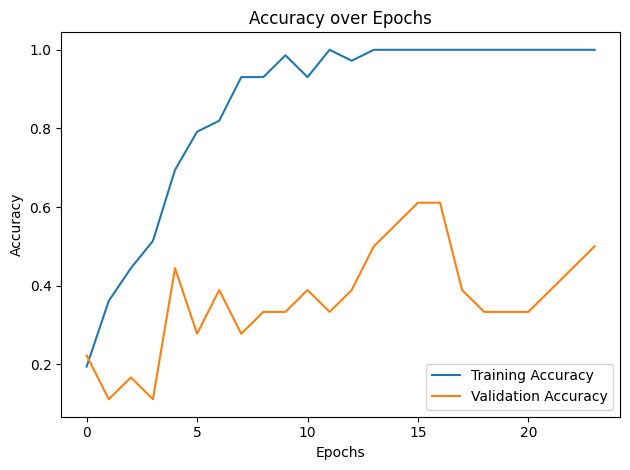

In [20]:
# Accuracy plot

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

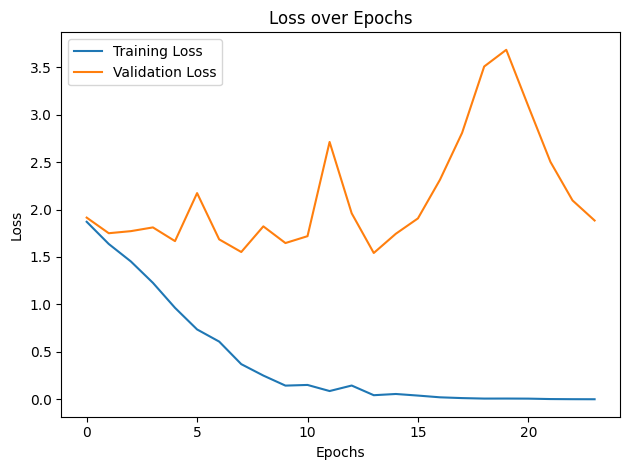

In [21]:

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Task - 1:
Repeat all the task from worksheet - 5 but, try to improve the model from last week with same dataset.
* Use Data Augmentation to increase the number of training image.
* Use deeper model with BN and DropOut layer as presented above.
* Understand the Model Summary and Training Behavior.

In [22]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [23]:
# Define an improved CNN model with Batch Normalization and Dropout
modelcnn2 = keras.Sequential([

    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=img_shape),

    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(6, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Compile the model
modelcnn2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [25]:
# Display model summary
modelcnn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,485,574 (32.37 MB)

 Trainable params: 8,484,614 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [26]:
# Train the model
cnn_history = modelcnn2.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=callbacks  # Callbacks for early stopping and saving the best model
    # jit_compile =False # Remove this line - it's not a valid argument for model.fit
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2390 - loss: 2.5569
Epoch 1: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2452 - loss: 2.5536 - val_accuracy: 0.2222 - val_loss: 1.7520
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4751 - loss: 2.0030
Epoch 2: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4744 - loss: 1.9646 - val_accuracy: 0.2222 - val_loss: 1.7431
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6065 - loss: 1.0620
Epoch 3: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5972 - loss: 1.1047 - val_accuracy: 0.2222 - val_loss: 1.7493
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6042 - loss: 1.0392
Epoch 4: val_loss did not improve from 1.54220
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6094 - loss: 1.0415 - val_accuracy: 0.2222 - val_loss: 1.7640
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━

In [27]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelcnn2.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.1667 - loss: 1.8329


Test Loss: 1.8329, Test Accuracy: 0.1667


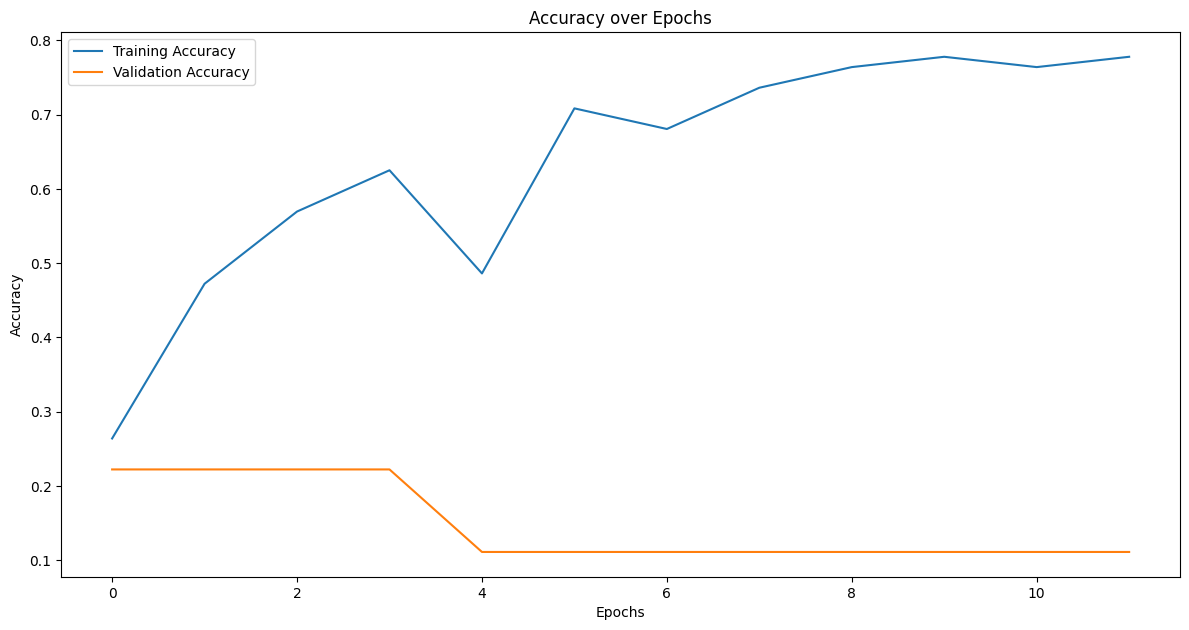

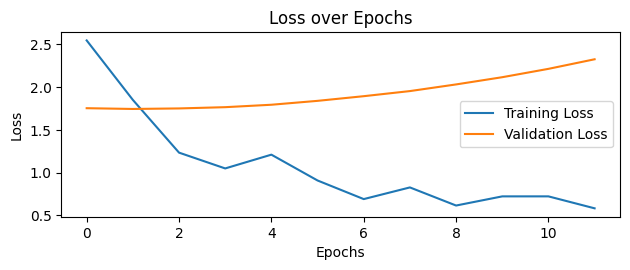

In [28]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# MobilenetV2


In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Define input shape
input_shape = (128, 128, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Adjust to your number of classes

# Create the model
modelnetv2 = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
from tensorflow.keras.optimizers import Adam

modelnetv2.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [31]:
vnet2_history = modelnetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.0793 - loss: 2.4340
Epoch 1: val_loss improved from 1.54220 to 1.50884, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0838 - loss: 2.4311 - val_accuracy: 0.4444 - val_loss: 1.5088
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5544 - loss: 1.2371
Epoch 2: val_loss improved from 1.50884 to 1.35927, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 0.5582 - loss: 1.2203 - val_accuracy: 0.3333 - val_loss: 1.3593
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7193 - loss: 0.7286
Epoch 3: val_loss improved from 1.35927 to 1.03828, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.7235 - loss: 0.7289 - val_accuracy: 0.6111 - val_loss: 1.0383
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8947 - loss: 0.3722
Epoch 4: val_loss improved from 1.03828 to 0.89048, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - accuracy: 0.8967 - loss: 0.3699 - val_accuracy: 0.7222 - val_loss: 0.8905
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 1.0000 - loss: 0.1389
Epoch 5: val_loss improved from 0.89048 to 0.85402, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step - accuracy: 1.0000 - loss: 0.1358 - val_accuracy: 0.7222 - val_loss: 0.8540
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9797 - loss: 0.1500
Epoch 6: val_loss improved from 0.85402 to 0.84698, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - accuracy: 0.9813 - loss: 0.1454 - val_accuracy: 0.7778 - val_loss: 0.8470
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9797 - loss: 0.1002
Epoch 7: val_loss improved from 0.84698 to 0.82787, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - accuracy: 0.9813 - loss: 0.0967 - val_accuracy: 0.7778 - val_loss: 0.8279
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 1.0000 - loss: 0.0646
Epoch 8: val_loss improved from 0.82787 to 0.82415, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - accuracy: 1.0000 - loss: 0.0637 - val_accuracy: 0.7778 - val_loss: 0.8241
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 1.0000 - loss: 0.0273
Epoch 9: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 1.0000 - loss: 0.0276 - val_accuracy: 0.7222 - val_loss: 0.8643
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 1.0000 - loss: 0.0206
Epoch 10: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 1.0000 - loss: 0.0211 - val_accuracy: 0.6667 - val_loss: 0.9261
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 1.0000 - loss: 0.0269
Epoch 11: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.7222 - val_loss: 0.9692
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - loss: 0.0190
Epoch 12: val_loss did not improve from 0.82415
3/3 ━━

In [32]:
modelnetv2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,752,212 (10.50 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,486 (1.26 MB)

In [33]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelnetv2.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8000 - loss: 0.5738


Test Loss: 0.5738, Test Accuracy: 0.8000


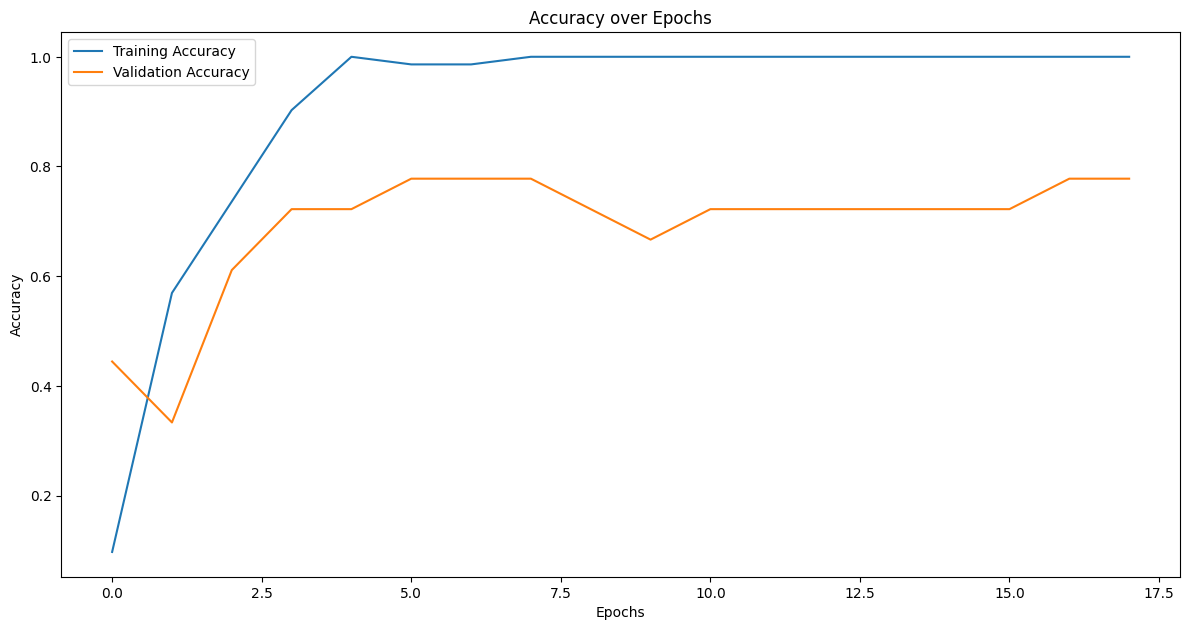

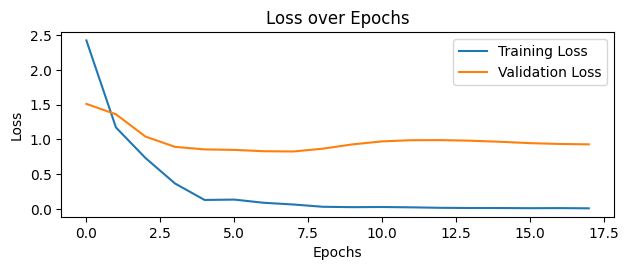

In [34]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(vnet2_history.history['accuracy'], label='Training Accuracy')
plt.plot(vnet2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(vnet2_history.history['loss'], label='Training Loss')
plt.plot(vnet2_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# VGG16

In [35]:
# --- Transfer Learning using VGG16 ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

In [36]:
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
for layer in base_model.layers:
  layer.trainable = False

In [38]:
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-class classification)


In [39]:
from tensorflow.keras.models import Model
# Create the final model
modelvgg16 = Model(inputs=base_model.input, outputs=x)

In [40]:
from tensorflow.keras.optimizers import Adam
# Compile the model
modelvgg16.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
vgg_history = modelvgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1991 - loss: 2.1354
Epoch 1: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.2049 - loss: 2.1176 - val_accuracy: 0.4444 - val_loss: 1.6476
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4705 - loss: 1.5453
Epoch 2: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.4674 - loss: 1.5406 - val_accuracy: 0.5000 - val_loss: 1.5722
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6505 - loss: 1.2456
Epoch 3: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.6476 - loss: 1.2457 - val_accuracy: 0.3889 - val_loss: 1.4765
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8003 - loss: 1.0184
Epoch 4: val_loss did not improve from 0.82415
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.7982 - loss: 1.0182 - val_accuracy: 0.5000 - val_loss: 1.3561
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━

In [42]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelvgg16.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4667 - loss: 1.3809


Test Loss: 1.3809, Test Accuracy: 0.4667


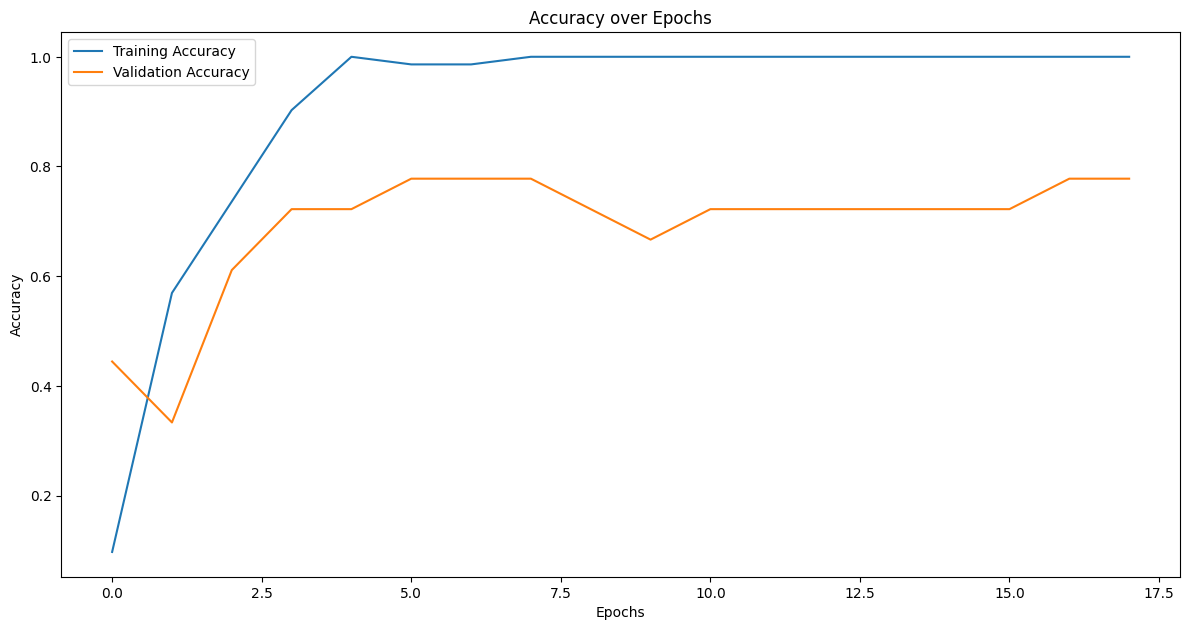

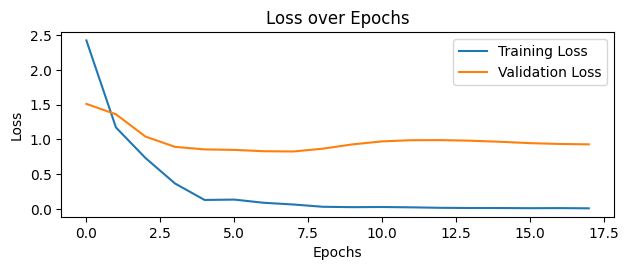

In [43]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(vnet2_history.history['accuracy'], label='Training Accuracy')
plt.plot(vnet2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(vnet2_history.history['loss'], label='Training Loss')
plt.plot(vnet2_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()